In [1]:
#pip3 install clean-fid numba numpy torch==2.0.0+cu118 torchvision --force-reinstall --extra-index-url https://download.pytorch.org/whl/cu118
#pip install pyg_lib torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118html
#pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu117.html
# check torch, torch-sparse, torch-scatter, pytorch_geometric versions

import random
import numpy as np

from torch import nn
import torch

import torch.nn.functional as F
from torch_geometric.data import Data

import torch_geometric.transforms as T
from torch_geometric.nn import SGConv
import pickle

import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv

import os
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [214]:
os.getcwd()

'/home/dhruvs/depaul_graphsage/trials'

### Graphsage Architecture

In [2]:
class GraphSAGE(torch.nn.Module):

    """
    input dimension: dimension of the feature vector
    output dimension: dimension of the node (this should be equal to the dmension of the trace)
    """
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.2):
        super().__init__()
        self.dropout = dropout
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, out_dim)
    
    def forward(self, data):
        x, adj_t = data.x, data.edge_index
        x = self.conv1(x, adj_t)
        x = F.sigmoid(x)
        x = F.dropout(x, p=self.dropout)
        
        x = self.conv2(x, adj_t)
        x = F.sigmoid(x)
        x = F.dropout(x, p=self.dropout)
        
        x = self.conv3(x, adj_t)
        x = F.sigmoid(x)
        x = F.dropout(x, p=self.dropout)
        #return torch.log_softmax(x, dim=-1)
        #print("output graphsage", x)
        return x

### MLP Architecture

In [216]:
"""
class MLP(torch.nn.Module):
    This will the one-hot encoded labels of all the nodes in the graph and output 
    a output_dim long vector

    input dim: vocab size
    output dim: 100 (a hyperparameter)
    def __init__(self, input_dim, output_dim, hidden_dim1, hidden_dim2):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, hidden_dim1)
        self.hidden_fc = nn.Linear(hidden_dim1,hidden_dim2)
        self.output_fc = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        # x = [num_nodes,vocab_size] (412, 412)
        h_1 = F.sigmoid(self.input_fc(x))
        # h_1 = [num_nodes, 200] (412, 200)

        h_2 = F.sigmoid(self.hidden_fc(h_1))
        # h_2 = [num_nodes, 150] (412, 150)

        output_mlp = self.output_fc(h_2)
        #output_mlp = [num_nodes, output_dim] (412, 100)

        return output_mlp
"""

'\nclass MLP(torch.nn.Module):\n    This will the one-hot encoded labels of all the nodes in the graph and output \n    a output_dim long vector\n\n    input dim: vocab size\n    output dim: 100 (a hyperparameter)\n    def __init__(self, input_dim, output_dim, hidden_dim1, hidden_dim2):\n        super().__init__()\n\n        self.input_fc = nn.Linear(input_dim, hidden_dim1)\n        self.hidden_fc = nn.Linear(hidden_dim1,hidden_dim2)\n        self.output_fc = nn.Linear(hidden_dim2, output_dim)\n\n    def forward(self, x):\n        # x = [num_nodes,vocab_size] (412, 412)\n        h_1 = F.sigmoid(self.input_fc(x))\n        # h_1 = [num_nodes, 200] (412, 200)\n\n        h_2 = F.sigmoid(self.hidden_fc(h_1))\n        # h_2 = [num_nodes, 150] (412, 150)\n\n        output_mlp = self.output_fc(h_2)\n        #output_mlp = [num_nodes, output_dim] (412, 100)\n\n        return output_mlp\n'

### LSTM Architecture

In [3]:
"""
class lstm(nn.Module):
	def __init__(self, batch_size, output_size, hidden_size, vocab_size):
		super(lstm, self).__init__()
		self.batch_size = batch_size
		self.output_size = output_size
		self.hidden_size = hidden_size
		self.vocab_size = vocab_size
		self.lstm = nn.LSTM(vocab_size, hidden_size)
		self.label = nn.Linear(hidden_size, output_size)


	def forward(self, input_sentence, batch_size=None):
		input = input_sentence.permute(1, 0, 2) 
		h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size))
		c_0 = Variable(torch.zeros(1, batch_size, self.hidden_size))
		output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))
		final_output = self.label(output) 
		#print("final_output from lstm", final_output)
		return (final_output)
"""

class BRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_dim):
        super(BRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_dim = output_dim

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True,
                            bidirectional = True)
        self.fc = nn.Linear(hidden_size*2, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)

        out, (hidden_state, cell_state) = self.lstm(x,(h0,c0))
        out = self.fc(out)
        return out

### Training

In [4]:
def train(model_graphsage, optimizer_graphsage,
        model_lstm, optimizer_lstm,
        data_nodeLabels, data_adjacencyMatrix):
    

    model_lstm.train()
    it = iter(train_iter)
    accuracy_batch_list = []
    loss_batch_list = []
    for i, batch in enumerate(it):
        
        # create a graphsage custom data
        #print("adj_2d inside train", adj_2d)
        #print("adj_2d inside train", batch)
        data = Data(x=data_nodeLabels, edge_index=adj_2d.t().contiguous())

        #call graphsage
        model_graphsage.train()
        optimizer_graphsage.zero_grad()
        out_graphsage = model_graphsage(data)

        model_lstm.train()
        optimizer_lstm.zero_grad()
        output_lstm = model_lstm(batch)
        
        loss_calc, result = calculate_loss(output_lstm, out_graphsage, batch)
        accuracy = evaluate_training(result, batch)
        accuracy_batch_list.append(accuracy)
        loss_batch_list.append(loss_calc.item())
        
        loss_calc.backward()
        
        optimizer_graphsage.step()
        optimizer_lstm.step()
    accuracy_entire_epoch = sum(accuracy_batch_list)/len(accuracy_batch_list)
    loss_entire_epoch = sum(loss_batch_list)/len(loss_batch_list)
    
    return (accuracy_entire_epoch, loss_entire_epoch)

### Loss function

In [5]:
def calculate_loss(output_lstm, out_graphsage, batch):
    # batch here is the true representation. This is because the vectors in batch are 
    # one hot encoded traces
    out_graphsage_reshaped = torch.transpose(out_graphsage, 0, 1)
    dot_product = torch.matmul(output_lstm, out_graphsage_reshaped)
    sm = nn.Softmax(dim=2)
    
    dot_product = sm(dot_product)
    
    loss_calc = loss_fn(dot_product,batch)
    #evaluate_training(c,batch)
    return (loss_calc, dot_product)

### Evaluate training accuracy

In [6]:
def evaluate_training(result, truth):
    
    argmaxed_result = torch.argmax(result, dim=2)
    argmaxed_truth = torch.argmax(truth, dim=2)
    #("argmaxed result:" , argmaxed_result)
    #print("argmaxed truth:" , argmaxed_truth)
    number_correctly_mapped = 0
    for i in range(len(argmaxed_result)):
        trace_res =  argmaxed_result[i]
        trace_orig = argmaxed_truth[i]
        if torch.equal(trace_res,trace_orig):
            number_correctly_mapped+= 1
    
    accuracy = number_correctly_mapped/len(argmaxed_result)

    return accuracy

### Dataset Preprocessing

#### Converting sparse adjacency matrix to dense

In [7]:
def structure_adjacency_matrix():
    """
    This method is to convert the original adjacency matrix into a 2 dimensional 
    adjacency matrix
    """
    adj_2d = []
    t_ind = 0
    for t in data_adjacencyMatrix:
        elem_ind = 0
        for elem in t:
            if elem == 1:
                a= [t_ind, elem_ind]
                adj_2d.append(a)
            elem_ind += 1
        t_ind = t_ind+1
    return torch.tensor(adj_2d)

#### Import trace data

In [8]:
traces = pickle.load(open("/home/dhruvs/depaul_graphsage/traces.pkl", "rb"))
traces = traces.int()
#traces = traces[:9900]
traces.shape

torch.Size([10, 3])

#### Import nodes and labels

In [9]:
data_nodeLabels = pickle.load(open("/home/dhruvs/depaul_graphsage/nodeLabels.pkl", "rb"))
data_adjacencyMatrix_old = pickle.load(open("/home/dhruvs/depaul_graphsage/adjacencyMatrix.pkl", "rb"))

data_adjacencyMatrix = data_adjacencyMatrix_old.type(torch.int64)


num_nodes_graph = data_adjacencyMatrix.shape[0]

In [10]:
num_nodes_graph

21

#### Converting traces to OHE

In [11]:
"""
traces = [[0,1,4,15,38],
[0,1,6,18,40],
[0,1,4,15,38],
[0,1,6,18,40]]
"""
all_traces_ohe = []
for t in traces:
    trace_ohe = []
    for t_node in t:
        node_pos = [0]*num_nodes_graph
        #node_pos.append(t_node)# attaching the node label
        node_pos[t_node] = 1
        trace_ohe.append(node_pos)
    all_traces_ohe.append(trace_ohe)

all_data= torch.FloatTensor(all_traces_ohe)
all_data.shape

torch.Size([10, 3, 21])

In [12]:
train_data = all_data
for i in range (50):
    train_data = torch.cat((train_data, all_data), 0)

train_data.shape

torch.Size([510, 3, 21])

In [13]:
train_data=train_data[torch.randperm(train_data.size()[0])]

In [14]:
# for now train data = all_data
train_data = all_data

In [15]:
data_nodeLabels.shape[1] #vocab size

21

### Defining hyperparameters and initiating the model

In [16]:
lr = 0.01
epochs = 10000
trace_length = traces.shape[1]


input_dim_graphsage = data_nodeLabels.shape[1]# input dimension of graphsage = output dimension of mlp
hidden_dim_graphsage = 10 #this is a hyperparameter
output_dim_graphsage = 5 #this is a hyperparameter

model_graphsage = GraphSAGE(in_dim=input_dim_graphsage, 
                 hidden_dim=hidden_dim_graphsage, 
                 out_dim= output_dim_graphsage)
optimizer_graphsage = torch.optim.Adam(model_graphsage.parameters(), lr=lr)

vocab_size = data_nodeLabels.shape[1]
batch_size = 10
output_size_lstm = output_dim_graphsage
hidden_size_lstm = 10
train_iter = DataLoader((train_data), batch_size = batch_size)

num_layers_lstm = 2
input_size_lstm = vocab_size
model_lstm = BRNN(input_size_lstm, hidden_size_lstm, num_layers_lstm, output_size_lstm)
#model_lstm = BRNN(batch_size, output_size_lstm, hidden_size_lstm, vocab_size)
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=lr)

adj_2d = structure_adjacency_matrix()

loss_fn = torch.nn.CrossEntropyLoss()

LOSS_EPOCHS = []
ACCURACY_EPOCHS = []
for epoch in range(1, 1 + epochs):
    accuracy_entire_epoch, loss_entire_epoch = train(
        model_graphsage, optimizer_graphsage,
        model_lstm, optimizer_lstm,
        data_nodeLabels, adj_2d)
    
    LOSS_EPOCHS.append(loss_entire_epoch)
    ACCURACY_EPOCHS.append(accuracy_entire_epoch)

print("Process complete")

Process complete


### Plotting Training loss and accuracy

No handles with labels found to put in legend.


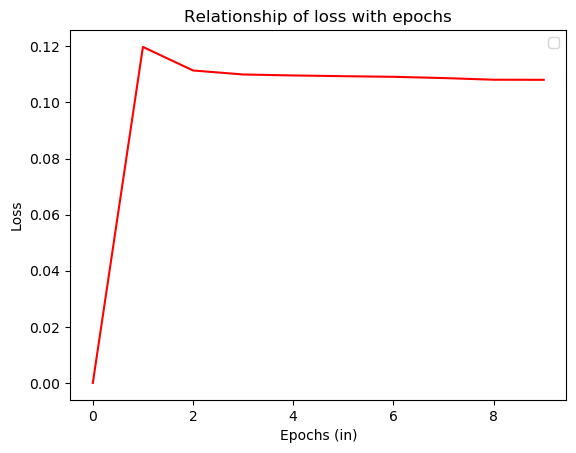

In [19]:
import matplotlib.pyplot as plt
EPOCHS_LIST = []
for i in range(10):
    EPOCHS_LIST.append(i)
LOSS = []
loss_per_thousand = 0
for i, loss in enumerate(LOSS_EPOCHS):
    if i%1000 != 0:
        loss_per_thousand+=loss
    else:
        LOSS.append(loss_per_thousand/1000)
        loss_per_thousand = 0

plt.plot(EPOCHS_LIST, LOSS, color='r')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs (in thousand)")
plt.ylabel("Loss")
plt.title("Relationship of loss with epochs")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

No handles with labels found to put in legend.


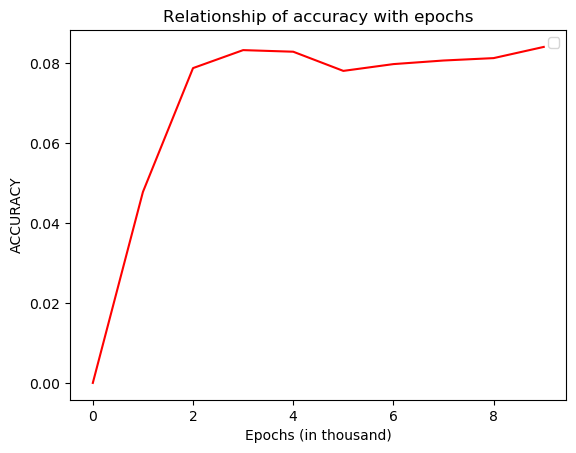

In [20]:
ACCURACY = []
accuracy_per_thousand = 0
for i, accuracy in enumerate(ACCURACY_EPOCHS):
    if i%1000 != 0:
        accuracy_per_thousand+=accuracy
    else:
        ACCURACY.append(accuracy_per_thousand/1000)
        accuracy_per_thousand = 0

plt.plot(EPOCHS_LIST, ACCURACY, color='r')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs (in thousand)")
plt.ylabel("ACCURACY")
plt.title("Relationship of accuracy with epochs")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

### Accuracy and Loss for each epoch

No handles with labels found to put in legend.


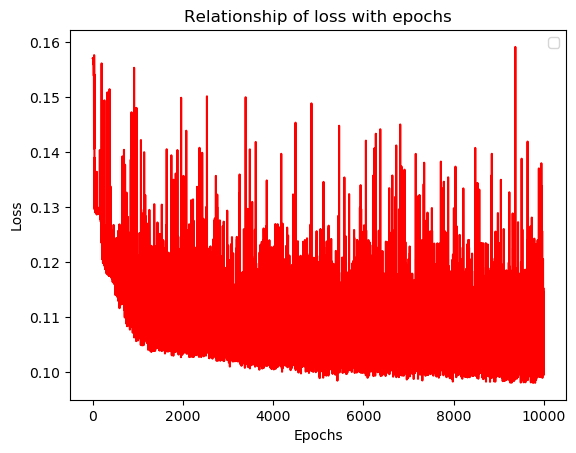

In [233]:

EPOCHS = []
for i in range(1,10001):
    EPOCHS.append(i)

plt.plot(EPOCHS, LOSS_EPOCHS, color='r')
#plt.plot(lam_list, LOSS_TEST, color='g', label='test loss')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Relationship of loss with epochs")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

No handles with labels found to put in legend.


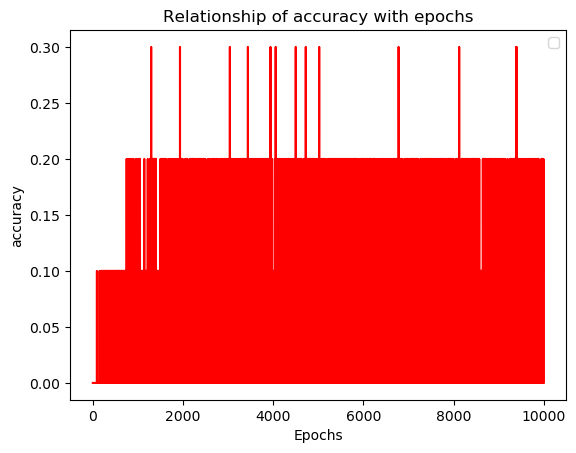

In [234]:
import matplotlib.pyplot as plt
EPOCHS = []
for i in range(1,10001):
    EPOCHS.append(i)

plt.plot(EPOCHS, ACCURACY_EPOCHS, color='r')
#plt.plot(lam_list, LOSS_TEST, color='g', label='test loss')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Relationship of accuracy with epochs")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

In [231]:
"""
def test_model(data_to_test):
    model_mlp.eval()
    with torch.no_grad():
        out_mlp = model_mlp(data_nodeLabels)

    data = Data(x=out_mlp, edge_index=adj_2d.t().contiguous())

    model_graphsage.eval()
    with torch.no_grad():
        graphsage_output = model_graphsage(data)

    model_lstm.eval()
    with torch.no_grad():
        lstm_test_result = model_lstm(data_to_test)

    accuracy = evaluate_test(lstm_test_result, data_to_test)
    return accuracy


def evaluate_test(result, truth):
    
    
    argmaxed_result = torch.argmax(result, dim=2)
    print("result", argmaxed_result)
    argmaxed_truth = torch.argmax(truth, dim=2)
    print("truth", argmaxed_truth)
    
    number_correctly_mapped = 0
    for i in range(len(argmaxed_result)):
        trace_res =  argmaxed_result[i]
        trace_orig = argmaxed_truth[i]
        if torch.equal(trace_res,trace_orig):
            number_correctly_mapped+= 1
    
    accuracy = number_correctly_mapped/len(argmaxed_result)

    return accuracy

# testing on train data again
test_accuracy = test_model(train_data)

print("Test Accuaracy is ", test_accuaracy)

"""

'\ndef test_model(data_to_test):\n    model_mlp.eval()\n    with torch.no_grad():\n        out_mlp = model_mlp(data_nodeLabels)\n\n    data = Data(x=out_mlp, edge_index=adj_2d.t().contiguous())\n\n    model_graphsage.eval()\n    with torch.no_grad():\n        graphsage_output = model_graphsage(data)\n\n    model_lstm.eval()\n    with torch.no_grad():\n        lstm_test_result = model_lstm(data_to_test)\n\n    accuracy = evaluate_test(lstm_test_result, data_to_test)\n    return accuracy\n\n\ndef evaluate_test(result, truth):\n    \n    \n    argmaxed_result = torch.argmax(result, dim=2)\n    print("result", argmaxed_result)\n    argmaxed_truth = torch.argmax(truth, dim=2)\n    print("truth", argmaxed_truth)\n    \n    number_correctly_mapped = 0\n    for i in range(len(argmaxed_result)):\n        trace_res =  argmaxed_result[i]\n        trace_orig = argmaxed_truth[i]\n        if torch.equal(trace_res,trace_orig):\n            number_correctly_mapped+= 1\n    \n    accuracy = number_corr